In [73]:
import h5py as h5
import glob
import numpy as np
import matplotlib.pyplot as plt

import sys

%load_ext autoreload
%autoreload 2

import OTRaPy.RamanSolver as RS
import OTRaPy.DataAnalysis.PeakAnalysis as PA
from OTRaPy.utils import * 
import json 

from scipy.optimize import minimize, least_squares
from scipy import integrate as integrate
from OTRaPy.Solvers.analytic_solver import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
kx = 62.2
ky = 62.2
g = 1.94E6 
Q = np.arange(0.01e-3,2e-3,0.25e-3)

Text(0, 0.5, '$\\mu$ m')

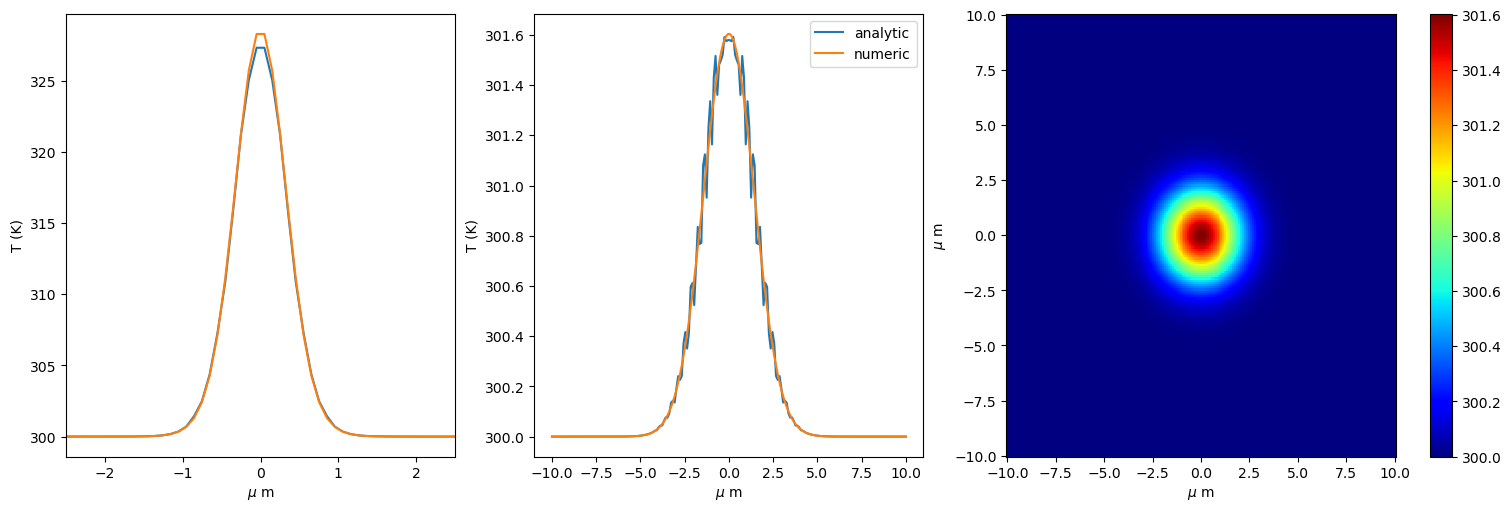

In [43]:
temp = RS.RamanSolver(nx=200,ny=200,lx=10e-6,ly=10e-6, h=0.7e-9, alpha=0.04, w0=0.4e-6,l0=0.4e-6)
f, (ax1,ax2, ax3)=plt.subplots(1,3,figsize=(15,5), constrained_layout=True)

T_num = temp.Txy()
T_an = temp.analytic_Txy()
ax1.plot(temp.x*1e6,T_an[0,:,100])
ax1.plot(temp.x*1e6,T_num[0,:,100])
ax1.set_xlim(-2.5,2.5)

temp.update_w0(2e-6)
temp.update_l0(2e-6)
T_num = temp.Txy()
T_an = temp.analytic_Txy()
ax2.plot(temp.x*1e6,T_an[0,:,100],label='analytic')
ax2.plot(temp.x*1e6,T_num[0,:,100],label='numeric')
ax2.legend()

im = ax3.pcolormesh(temp.X[0]*1e6, temp.Y[0]*1e6, T_num[0], cmap='jet')
f.colorbar(im)

ax1.set_xlabel(r'$\mu$ m')
ax2.set_xlabel(r'$\mu$ m')
ax3.set_xlabel(r'$\mu$ m')
ax1.set_ylabel(r'T (K)')
ax2.set_ylabel(r'T (K)')
ax3.set_ylabel(r'$\mu$ m')

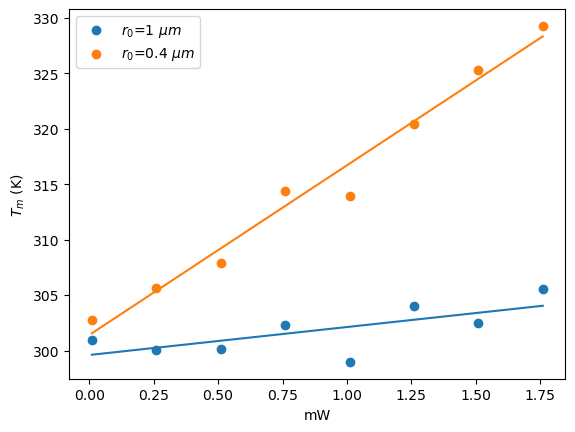

In [98]:
r1 = 1e-6
temp.update_w0(r1)
temp.update_l0(r1)
exp_data_r1 = temp.dTdQ_sim(kx,ky,g,Q)
exp_data_r1 += 1.5*np.random.normal(size=exp_data_r1.shape)
popt, pcov = curve_fit(linear, Q, exp_data_r1)
exp_slope_r1 = popt[0]
plt.scatter(Q*1e3,exp_data_r1, label=r'$r_0$=1 $\mu m$')
plt.plot(Q*1e3, linear(Q, *popt))

r2 = 0.4e-6
temp.update_w0(r2)
temp.update_l0(r2)
exp_data_r2 = temp.dTdQ_sim(kx,ky,g,Q)
exp_data_r2 += 1.5*np.random.normal(size=exp_data_r2.shape)
popt, pcov = curve_fit(linear, Q, exp_data_r2)
exp_slope_r2 = popt[0]
plt.scatter(Q*1e3,exp_data_r2, label=r'$r_0$=0.4 $\mu m$')
plt.plot(Q*1e3, linear(Q, *popt))

plt.xlabel('mW')
plt.ylabel(r'$T_m$ (K)')
plt.legend()

In [138]:
root = minimize(temp.analytic_loss, args=(exp_slope_r1, exp_slope_r2, r1, r2),x0=2, bounds=((0.,np.inf),),tol=4e-7)
ratio = root.x[0]

0.5991672304488715
0.5991672303028661
0.5989546527194874
0.598954652574299
0.5722605449141919
0.5722605448371677
0.5537088771734021
0.5537088771204096
0.5270157501273594
0.527015750094212
0.4985733246600693
0.4985733246386096
0.4650756653086323
0.4650756652949837
0.42782563016246944
0.4278256301537937
0.3866963613465494
0.38669636134109064
0.34243729125916156
0.3424372912557506
0.2971314719953199
0.2971314719932197
0.2525598254574815
0.2525598254561988
0.21006049323051545
0.21006049322974157
0.17145355338882773
0.1714535533883647
0.14343904870607216
0.1434390487058096
0.11746982877742457
0.11746982877726575
0.09854712401712945
0.09854712401704163
0.07721627199603345
0.07721627199597958
0.06210378921212156
0.06210378921209295
0.05271592859015076
0.052715928590134464
0.04449401596776864
0.04449401596775973
0.04181163961263304
0.0418116396126291


In [107]:
k1 = (2 * temp.alpha)  / (r1**4 * temp.h * np.pi * exp_slope_r1) * (integrate.quad(integrand_Tm_solve, 0,200e-6,args=(root.x,r1,temp.h))[0])
g1 = k1*root.x[0]/1e6

k2 = (2 * temp.alpha)  / (r2**4 * temp.h * np.pi * exp_slope_r2) * (integrate.quad(integrand_Tm_solve, 0,200e-6,args=(root.x,r2,temp.h))[0])
g2 = k2*root.x[0]/1e6

print(k1,g1)
print(k2,g2)

57.71676291459651 1.6897430577094508
112.64838938104157 3.2979471527261883


In [ ]:
root_k1 = least_squares(solve_k_from_ratio, x0=62, args=(ratio, 1e-6, exp_slope_r1, Q))
root_k2 = least_squares(solve_k_from_ratio, x0=62, args=(ratio, 0.4e-6, exp_slope_r2, Q))

k1 = root_k1.x[0]
g1 = k1 * ratio 

k2 = root_k2.x[0]
g2 = k2 * ratio 

In [158]:
k1, g1, k2, g2, k_av, g_av = temp.get_props_analytic(60, ratio, 1e-6, 0.4e-6, exp_slope_r1, exp_slope_r2, Q, verbose=True)

solving k1
[952.07995475]
[952.07990299]
[204.79726597]
[204.79722534]
[14.30962247]
[14.30958468]
[0.08040572]
[0.08036814]
[3.03075285e-06]
[3.45491785e-05]
[6.64482468e-06]
solving k2
[2931.76810832]
[2931.76783663]
[406.1123923]
[406.11215825]
[10.23490789]
[10.23467974]
[0.00685673]
[0.00662872]
[7.0212991e-10]
[0.000228]
[2.47382559e-10]
[0.000228]


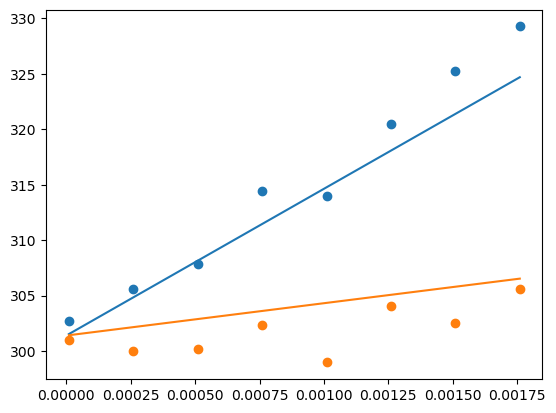

In [153]:
temp.update_w0(0.4e-6)
temp.update_l0(0.4e-6)
plt.scatter(Q, exp_data_r2)
plt.plot(Q, linear(Q, temp.dTdQ(k1, k1, g1,Q),popt[-1]))


temp.update_w0(1e-6)
temp.update_l0(1e-6)
plt.scatter(Q, exp_data_r1)
plt.plot(Q, linear(Q, temp.dTdQ(k2, k2, g2,Q),popt[-1]))


In [210]:
dTdQ_w1, dTdQ_w2, w1, w2 = 39337.823644938675, 59142.12801928839, 4e-6, 1e-6
temp.alpha = 1
temp.get_ratio(dTdQ_w1, dTdQ_w2, w1, w2, 0.1e6/35, bounds=((0.,np.inf),),tol=4e-7)
ratio = temp.found_ratio

k1, g1, k2, g2, k_av, g_av = temp.get_props_analytic(15, ratio, w1, w1, dTdQ_w1, dTdQ_w2, Q, verbose=True)

0.5817693755136143
0.5817693755136722
0.5817693754800173
0.5817693754800752
solving k1
[186054.23949716]
[186054.23613856]
[84132.96241787]
[84132.96057801]
[40433.7407202]
[40433.73953151]
[13600.81156615]
[13600.8107773]
[2780.00735001]
[2780.0067224]
[172.13669684]
[172.1361081]
[0.746256]
[0.74566981]
[1.78937626e-05]
[0.00056828]
[3.69503687e-05]
solving k2
[166249.93512281]
[166249.93176421]
[70572.24795638]
[70572.24602348]
[24866.60688033]
[24866.60562851]
[5679.37286193]
[5679.37189601]
[457.52400998]
[457.52312188]
[3.48446534]
[3.48358401]
[0.00020348]
[0.00067781]
[0.00058154]


In [238]:
# maybe don't take average, just take which fits the line better.... 

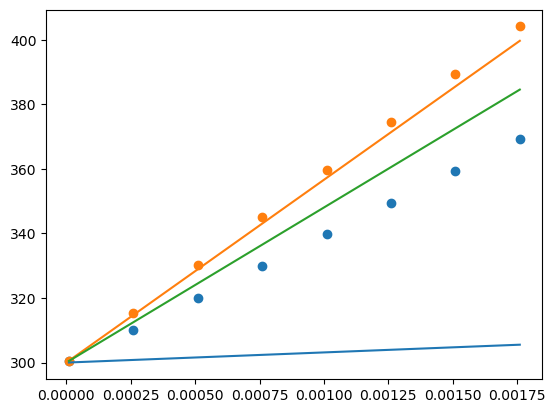

In [ ]:
temp.alpha = 0.08
temp.update_w0(w1)
temp.update_l0(w1)
plt.scatter(Q, linear(Q, dTdQ_w1, 300))
plt.plot(Q, linear(Q, temp.dTdQ(k1, k1, g1,Q),300))

temp.update_w0(w2)
temp.update_l0(w2)
plt.scatter(Q, linear(Q, dTdQ_w2, 300))
plt.plot(Q, linear(Q, temp.dTdQ(k2, k2, g2,Q),300))


In [725]:
r_array = r_from_zl(1e-6,z_4_24*1e-6,0.36)
solver = RS.RamanSolver(lx=10E-6, ly=10E-6, nx=200,ny=200,h=0.7E-9,alpha=0.08,w0=r_array,l0=r_array)
root = solver.get_g_fixk([1.5E6], da_4_24, pwr, bounds=([0.1E6], [30E6]), kx=0,ky=0,)

In [450]:
dTdQ_w1, dTdQ_w2, w1, w2 = 39337.823644938675, 59142.12801928839, 4e-6, 1e-6
w1 = 1e-6
temp.update_w0(w1)
temp.update_l0(w1)
dTdQ_w1 = temp.dTdQ(kx=62.2,ky=62.2,g=1.94E6,Q=np.arange(0.01e-3,1e-3, 1e-4))

w2 = 0.4e-6
temp.update_w0(w2)
temp.update_l0(w2)
dTdQ_w2 = temp.dTdQ(kx=62.2,ky=62.2,g=1.94E6,Q=np.arange(0.01e-3,1e-3, 1e-4))


test = solve_ratio()
test.Rm1 = dTdQ_w1[0]
test.Rm2 = dTdQ_w2[0]
test.h = temp.h 
test.r1 = w1
test.r2 = w2

test.thermal_properties()

[40000.]
k1:1557.1875761602535 W/mK, g1:62.288 MW/m2K
k1_err:28.36746087119052 W/mK, g1_err:1.135 MW/m2K


k2:1443.1234162891883 W/mK, g2:57.725 MW/m2K
k2_err:2487.3294851338096 W/mK, g1_err:99.493 MW/m2K


In [433]:
temp.h

7e-10

In [280]:
temp.update_w0(1e-6)
Tm1 = temp.weighted_average(temp.Txy()[0])
temp.update_w0(0.4e-6)
Tm2 = temp.weighted_average(temp.Txy()[0])
Tm1/Tm2

array([0.97027161])